# Study of Variable Stars

In this notebook, we study the variability of the star _RR Lyrae_. We first download the data (flux, error in flux and magnitude) of the object from the Gaia data archive.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize as mz
from scipy.signal import lombscargle as lsg

Below, we read data from the `.csv` file. We use `pandas` to do so.

In [2]:
data = pd.read_csv('anonymous1619179984702__1.csv', delimiter=',')
data

,#source_id,#transit_id,#band,#time,#mag,#flux,#flux_error,#flux_over_error,#rejected_by_photometry,#rejected_by_variability,#other_flags,#solution_id
0,5.870124e+18,1.681597e+16,G,1700.950782,14.724688,24292.428930,98.580601,246.42200,False,False,4097,3.692955e+17
1,5.870124e+18,1.682006e+16,G,1701.024756,14.702327,24797.924165,50.900513,487.18417,False,False,4198913,3.692955e+17
2,5.870124e+18,1.871648e+16,G,1735.318589,13.882563,52761.984514,143.748034,367.04492,False,False,4198913,3.692955e+17
3,5.870124e+18,1.872057e+16,G,1735.392621,13.882467,52766.643189,114.407901,461.21503,False,False,4097,3.692955e+17
4,5.870124e+18,2.135727e+16,G,1783.075027,13.783556,57799.484973,252.404070,228.99585,False,False,4097,3.692955e+17
...,...,...,...,...,...,...,...,...,...,...,...,...
56,5.870124e+18,4.471915e+16,G,2205.565177,15.532265,11546.231954,40.272931,286.69960,False,False,4097,3.692955e+17
57,5.870124e+18,4.606941e+16,G,2229.985599,16.023096,7346.965467,55.085382,133.37415,False,False,4097,3.692955e+17
58,5.870124e+18,4.607350e+16,G,2230.059611,16.028770,7308.666183,34.368098,212.65845,False,False,4097,3.692955e+17
59,5.870124e+18,4.770002e+16,G,2259.476499,16.255946,5928.814501,33.871020,175.04092,False,False,167937,3.692955e+17


In [3]:
time, flx, flx_err, mag = data['#time'].to_numpy(), data['#flux'].to_numpy(), data['#flux_over_error'].to_numpy(), data['#mag'].to_numpy()

Note, that the data do not contain the error in magnitude, which we can compute from the error in the flux. We know that,

$$M =-2.5\log{F} + C_0$$

where, $M$, $F$ and $C_0$ corresponds to the magnitude, flux and the reference point, respectively. To find the error in $M$, we can derive above equation to find that,

$$dM = 2.5\frac{1}{\ln{10}}\frac{dF}{F}$$

$$\Rightarrow dM = 1.086\frac{dF}{F}$$

below, we use this formula to find the error in magnitudes.

## Variability visulization

Below we present the plots of time v/s flux and time v/s magnitude to show the variability of the star.

In [4]:
mag_err = 1.086*flx_err/flx

In [5]:
# Un-weighted mean, median: Flux
mn_fl, md_fl = np.average(flx), np.median(flx)
# Weighted mean: flux
mn_fl_wt = np.average(flx, weights=flx_err**-2)
#IQR
fl_iqr25, fl_iqr75 = np.quantile(flx, np.array([0.25,0.75]))

print('Un-weighted mean of the flux: ', mn_fl)
print('Weighted mean of the flux: ', mn_fl_wt)
print('Median of the flux: ', md_fl)
print('IQR: ' + '[' + str(fl_iqr25) + ', ' + str(fl_iqr75) + ']')

Un-weighted mean of the flux:  31621.358221995797
Weighted mean of the flux:  10841.111507510179
Median of the flux:  29101.7309006603
IQR: [6497.43501033047, 56285.4943178413]


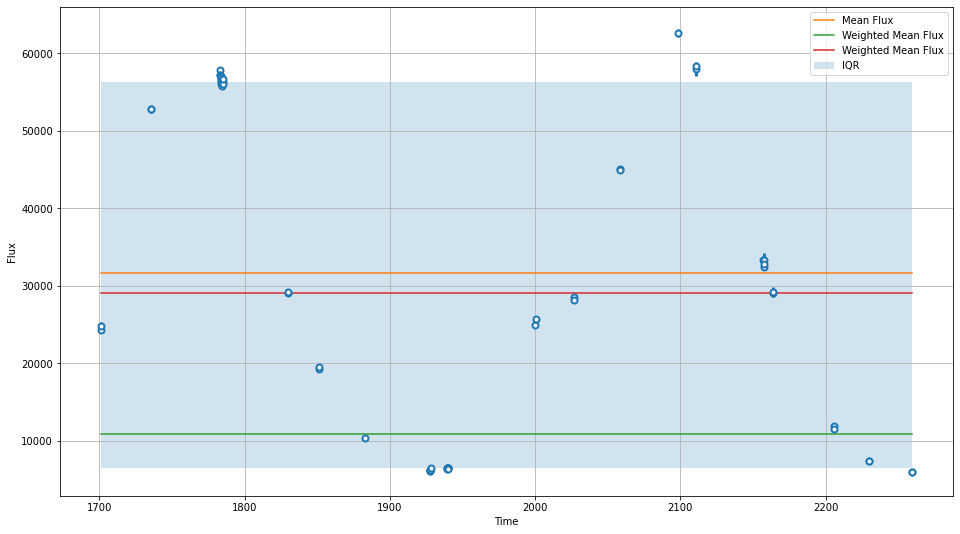

In [6]:
plt.figure(figsize=(16,9))
plt.errorbar(time, flx, yerr=flx_err, fmt='o', mfc='white', elinewidth=3, mew=2)
plt.plot(time, mn_fl*np.ones(len(flx)), label='Mean Flux')
plt.plot(time, mn_fl_wt*np.ones(len(flx)), label='Weighted Mean Flux')
plt.plot(time, md_fl*np.ones(len(flx)), label='Weighted Mean Flux')
plt.fill_between(time, fl_iqr25*np.ones(len(flx)), fl_iqr75*np.ones(len(flx)), alpha=0.2, label='IQR')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(loc='best')
plt.grid()

In [7]:
# Un-weighted mean, median: Magnitude
mn_mag, md_mag = np.average(mag), np.median(mag)
# Weighted mean: flux
mn_mag_wt = np.average(mag, weights=mag_err**-2)
#IQR
mag_iqr25, mag_iqr75 = np.quantile(mag, np.array([0.25,0.75]))

print('Un-weighted mean of the flux: ', mn_mag)
print('Weighted mean of the flux: ', mn_mag_wt)
print('Median of the flux: ', md_mag)
print('IQR: ' + '[' + str(mag_iqr25) + ', ' + str(mag_iqr75) + ']')

Un-weighted mean of the flux:  14.806319684034769
Weighted mean of the flux:  14.366306147071917
Median of the flux:  14.5285686737673
IQR: [13.8123745137203, 16.1565108645546]


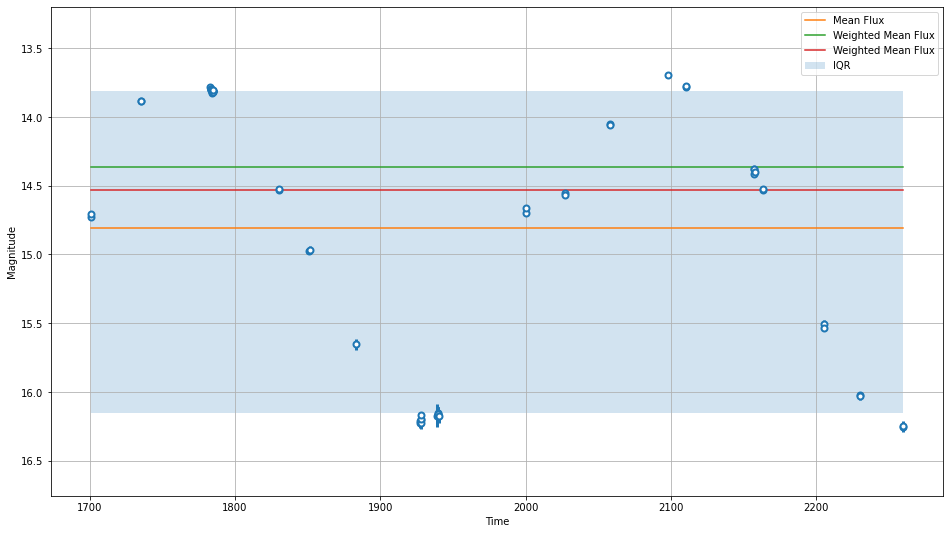

In [8]:
plt.figure(figsize=(16,9))
plt.errorbar(time, mag, yerr=mag_err, fmt='o', mfc='white', elinewidth=3, mew=2)
plt.plot(time, mn_mag*np.ones(len(mag)), label='Mean Flux')
plt.plot(time, mn_mag_wt*np.ones(len(mag)), label='Weighted Mean Flux')
plt.plot(time, md_mag*np.ones(len(mag)), label='Weighted Mean Flux')
plt.fill_between(time, mag_iqr25*np.ones(len(mag)), mag_iqr75*np.ones(len(mag)), alpha=0.2, label='IQR')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc='best')
plt.ylim([np.max(mag)+0.5, np.min(mag)-0.5])
plt.grid()

## Un-weighted mean or weighted mean?

It is evident from both of above plots that magnitudes are much more regular -- we would work with magnitudes. However, it is not clear if we want to use the weighted mean or the un-weighted mean in our usage. To test that which is better to use, we perform a small simulation. We simulte an observation with true flux 50, and we take 15 observations -- since this process follows the Poisson distribution, we use `numpy.random.poisson` module to sample Poisson distribution of our observations. We then find the weighted mean and un-weighted mean of this observation. We repeat this procedure for many times and then we see which type of mean is more near (or more times occur) to the true mean value of flux.

In [9]:
num_obs = 15
flux_true = 50

# Poisson distribution of flux to test the function
poi_flx = np.random.poisson(flux_true, num_obs)
print('Poisson distribution: ', poi_flx)
poi_flx_err = poi_flx**0.5
print('Error in it: ', poi_flx_err)

Poisson distribution:  [56 49 45 42 51 38 50 49 65 51 43 41 51 60 47]
Error in it:  [7.48331477 7.         6.70820393 6.4807407  7.14142843 6.164414
 7.07106781 7.         8.06225775 7.14142843 6.55743852 6.40312424
 7.14142843 7.74596669 6.8556546 ]


In [10]:
print('Un-weighted mean of the sampled distribution: ', np.average(poi_flx))
print('Weighted mean of the sampled distribution: ', np.average(poi_flx, weights=poi_flx_err**-2))

Un-weighted mean of the sampled distribution:  49.2
Weighted mean of the sampled distribution:  48.25968032750071


In [11]:
means = np.zeros(10000)
wt_means = np.zeros(10000)

for i in range(len(means)):
    poi_flxs = np.random.poisson(flux_true, num_obs)
    poi_flxs_err = poi_flxs**0.5
    means[i] = np.average(poi_flxs)
    wt_means[i] = np.average(poi_flxs, weights=poi_flxs_err**-2)

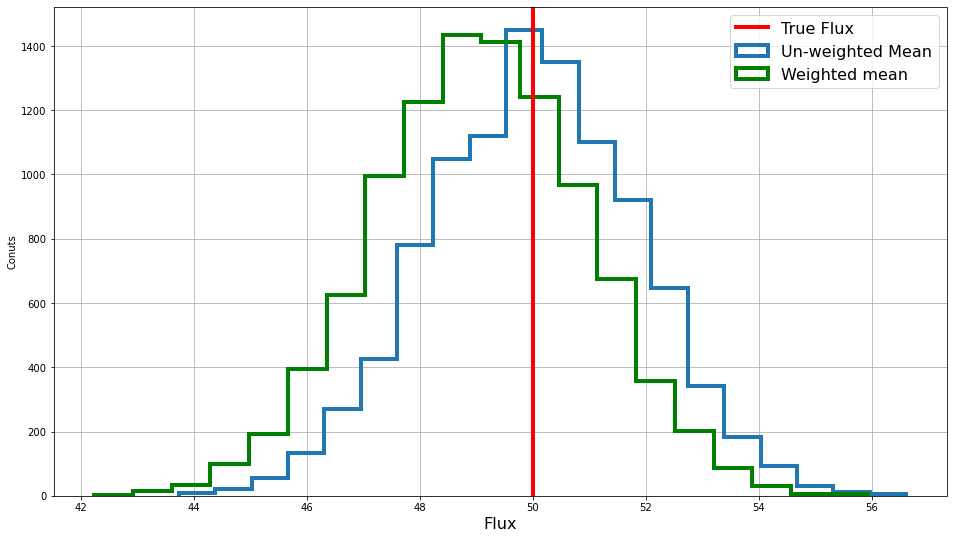

In [12]:
plt.figure(figsize=(16,9))
plt.hist(means, bins=20, histtype='step', linewidth=4, label='Un-weighted Mean')
plt.hist(wt_means, bins=20, histtype='step', color='g', linewidth=4, label='Weighted mean')
plt.axvline(50, c='r', label='True Flux', linewidth=4)
plt.xlabel('Flux', fontsize=16)
plt.legend(fontsize=16, loc='best')
plt.xlabel('Flux')
plt.ylabel('Conuts')
plt.grid()
plt.show()

It is now clear from above figure that un-weighted mean better describe the true flux than the weighted mean.

## Lomb-scargle analysis

We now try to find the periodicity in our time series data by using the Lomb-Scargle algorithm. Below, we present this analysis.

In [13]:
days = np.linspace(1,365*5,10000)
freq = 2*np.pi/days
power = lsg(time, flx, freq)

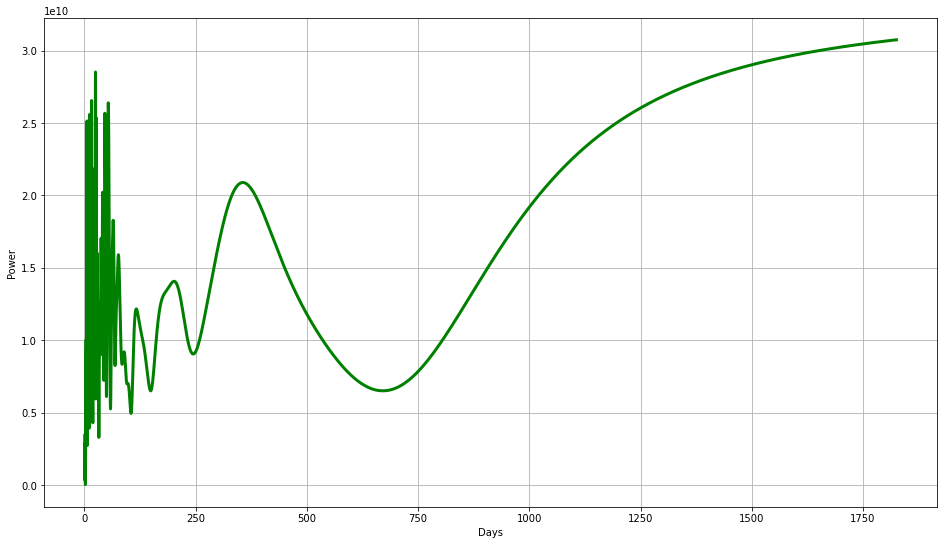

In [14]:
plt.figure(figsize=(16,9))
plt.plot(days, power, c='g', linewidth=3)
plt.xlabel('Days')
plt.ylabel('Power')
plt.grid()

Although there is a local maximum near $\sim 300 \ days$, it certainly not the global maximum!!!

## Modelling using scipy

Below, we try to fit a sinusoidal function to the variablity of magnitude to find the period of the variablity of the star.

In [ ]:
def func():
    